# Melanoma Detection

Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data

### Importing all the important libraries

In [1]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import shutil
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

In [2]:
## If you are using the data by mounting the google drive, use the following:
##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [3]:
# Defining the path for train and test images
data_dir_train = pathlib.Path("/content/gdrive/MyDrive/Melanoma-detection/data/Train")
data_dir_test = pathlib.Path("/content/gdrive/MyDrive/Melanoma-detection/data/Test")
print(data_dir_test)
print(data_dir_train)

/content/gdrive/MyDrive/Melanoma-detection/data/Test
/content/gdrive/MyDrive/Melanoma-detection/data/Train


In [4]:
# getting the image count in train and test data
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2244
118


#### Utility Functions

In [5]:
# function to delete the augmented images folder

def remove_augmented_data_directory(data_dir):
  class_names = [ item for item in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, item)) ]
  for class_name in class_names:
    dir_path = pathlib.Path(os.path.join(data_dir, class_name, 'output'))
    print(dir_path)
    shutil.rmtree(dir_path, ignore_errors=True)

#### Removing the augmented images data from the disk

In [6]:
remove_augmented_data_directory(data_dir_train)

/content/gdrive/MyDrive/Melanoma-detection/data/Train/vascular lesion/output
/content/gdrive/MyDrive/Melanoma-detection/data/Train/nevus/output
/content/gdrive/MyDrive/Melanoma-detection/data/Train/melanoma/output
/content/gdrive/MyDrive/Melanoma-detection/data/Train/basal cell carcinoma/output
/content/gdrive/MyDrive/Melanoma-detection/data/Train/dermatofibroma/output
/content/gdrive/MyDrive/Melanoma-detection/data/Train/squamous cell carcinoma/output
/content/gdrive/MyDrive/Melanoma-detection/data/Train/actinic keratosis/output
/content/gdrive/MyDrive/Melanoma-detection/data/Train/pigmented benign keratosis/output
/content/gdrive/MyDrive/Melanoma-detection/data/Train/seborrheic keratosis/output


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [7]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [8]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = image_dataset_from_directory(
    data_dir_train,
    label_mode='categorical',
    validation_split=0.2,
    subset='training',
    seed=123,
    batch_size=batch_size,
    image_size=(img_height, img_width))

Found 2244 files belonging to 9 classes.
Using 1796 files for training.


In [9]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = image_dataset_from_directory(
    data_dir_train,
    label_mode='categorical',
    validation_split=0.2,
    subset='validation',
    seed=123,
    batch_size=batch_size,
    image_size=(img_height, img_width))

Found 2244 files belonging to 9 classes.
Using 448 files for validation.


In [10]:
# List out all the classes of skin cancer and store them in a list. 
# You can find the class names in the class_names attribute on these datasets. 
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

In [11]:
# function to display one image for each of the classes present in the dataset

def display_one_image_per_class(dataset):
  plt.figure(figsize=(10, 10))
  for class_ind in range(len(dataset.class_names)):
    image_found = False
    while not image_found:
      for images, labels in dataset:
        if not image_found:
          for i in range(batch_size):
          # if(class_ind == labels[i]):
            if np.where(labels[i] == 1)[0] == class_ind:
              ax = plt.subplot(3, 3, class_ind + 1)
              plt.imshow(images[i].numpy().astype("uint8"))
              plt.title(class_names[class_ind])
              plt.axis("off")
              image_found = True
              break
        break
      

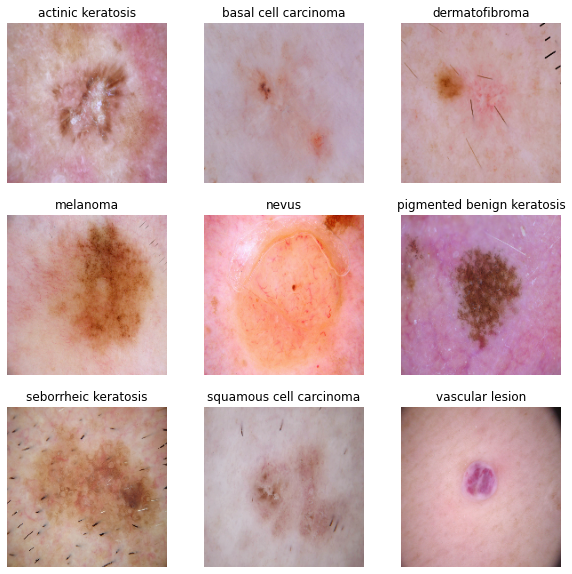

In [12]:
# displaying one image per class in the train dataset
display_one_image_per_class(train_ds)

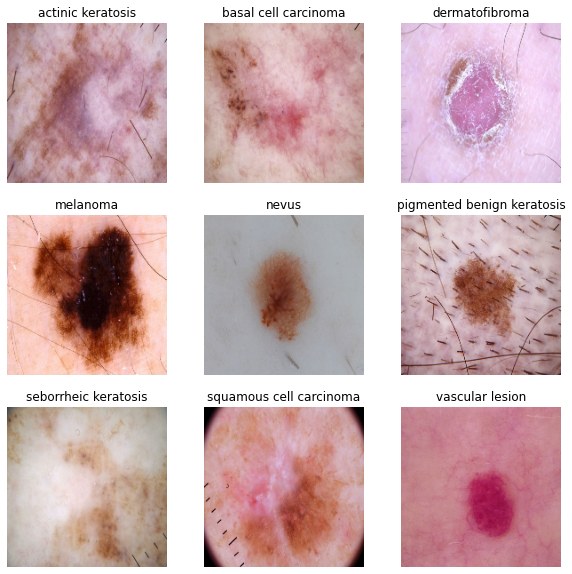

In [13]:
# displaying one image per class in the validation dataset
display_one_image_per_class(val_ds)

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [14]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [15]:
### normalization layer that will normalize the input image data
normalization_layer = tf.keras.layers.Rescaling(1./255, input_shape=(img_height, img_width, 3))

In [16]:
num_classes = len(class_names)
print(num_classes)

9


In [17]:
# create the sequential model
model = Sequential()

model.add(normalization_layer)
model.add(Conv2D(16, 3, padding='same', activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(32, 3, padding='same', activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(64, 3, padding='same', activation='relu'))
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))

### Compile the model
Choose an appropirate optimiser and loss function for model training 

In [18]:
### Todo, choose an appropirate optimiser and loss function
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [19]:
# View the summary of all layers
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 64)        1

### Train the model

In [20]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
57/57 [==============================] - 193s 365ms/step - loss: 2.0067 - accuracy: 0.2533 - val_loss: 1.8443 - val_accuracy: 0.3438
Epoch 2/20
57/57 [==============================] - 2s 43ms/step - loss: 1.7878 - accuracy: 0.3519 - val_loss: 1.6061 - val_accuracy: 0.4085
Epoch 3/20
57/57 [==============================] - 2s 42ms/step - loss: 1.5854 - accuracy: 0.4388 - val_loss: 1.4331 - val_accuracy: 0.5156
Epoch 4/20
57/57 [==============================] - 2s 42ms/step - loss: 1.4329 - accuracy: 0.4883 - val_loss: 1.6817 - val_accuracy: 0.3996
Epoch 5/20
57/57 [==============================] - 2s 42ms/step - loss: 1.3894 - accuracy: 0.5111 - val_loss: 1.4434 - val_accuracy: 0.4844
Epoch 6/20
57/57 [==============================] - 2s 42ms/step - loss: 1.2980 - accuracy: 0.5434 - val_loss: 1.2939 - val_accuracy: 0.5424
Epoch 7/20
57/57 [==============================] - 2s 42ms/step - loss: 1.2239 - accuracy: 0.5618 - val_loss: 1.4259 - val_accuracy: 0.5558
Epoch 8/20

### Visualizing training results

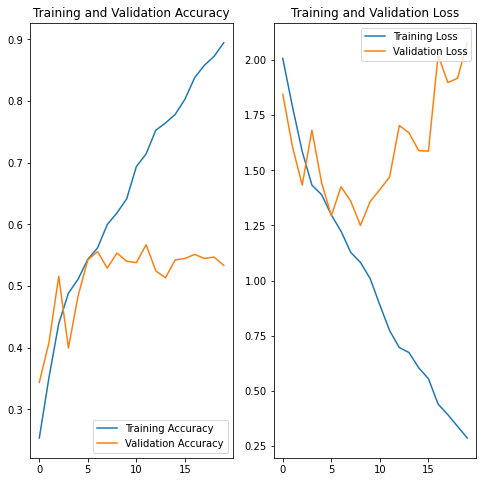

In [21]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### From the plots above we can see that there is a huge difference between training accuracy and validation accuracy of the model implying that there is a case of overfitting.

#### The reason for the above overfitting either can be due to less training images available or due to a complex model. We need to try both the techniques and see it impact on the performance of our model.




### Data Augmentation using Keras preprocessing layers

In [22]:
# Todo, after you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy. 
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal_and_vertical", input_shape=(img_height, img_width, 3), seed=123),
    layers.RandomRotation((-0.5, 0.5), seed=123),
    layers.RandomZoom((-0.5, 0.5), seed=123),
    layers.RandomContrast((0.1, 0.5), seed=123)
  ]
)


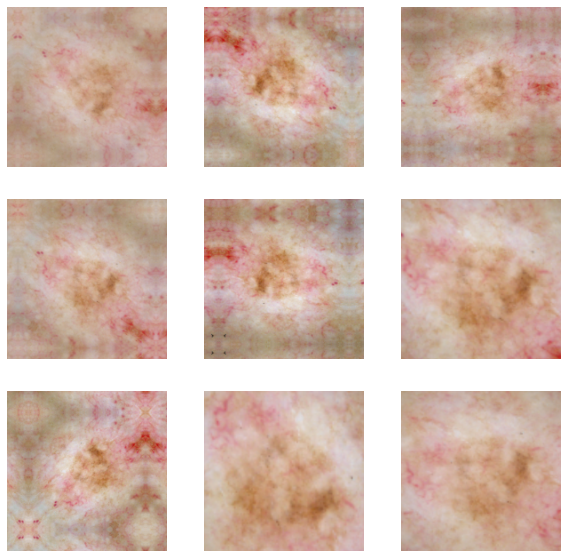

In [23]:
# Todo, visualize how your augmentation strategy works for one instance of training image.
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")


### Todo:
### Create the model, compile and train the model


In [24]:
model = Sequential()

model.add(data_augmentation)
model.add(normalization_layer)
model.add(Conv2D(16, 3, padding='same', activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(32, 3, padding='same', activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(64, 3, padding='same', activation='relu'))
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))


### Compiling the model

In [25]:
### Todo, choose an appropirate optimiser and loss function
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 90, 90, 16)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                  

### Training the model

In [26]:
## Your code goes here, note: train your model for 20 epochs
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
57/57 [==============================] - 5s 57ms/step - loss: 1.8603 - accuracy: 0.3157 - val_loss: 1.6309 - val_accuracy: 0.4732
Epoch 2/20
57/57 [==============================] - 3s 52ms/step - loss: 1.6095 - accuracy: 0.4365 - val_loss: 1.5587 - val_accuracy: 0.4799
Epoch 3/20
57/57 [==============================] - 3s 52ms/step - loss: 1.4850 - accuracy: 0.4905 - val_loss: 1.4333 - val_accuracy: 0.4799
Epoch 4/20
57/57 [==============================] - 3s 53ms/step - loss: 1.5002 - accuracy: 0.4588 - val_loss: 1.4496 - val_accuracy: 0.4866
Epoch 5/20
57/57 [==============================] - 3s 51ms/step - loss: 1.4560 - accuracy: 0.5078 - val_loss: 1.4235 - val_accuracy: 0.5089
Epoch 6/20
57/57 [==============================] - 3s 51ms/step - loss: 1.4223 - accuracy: 0.4955 - val_loss: 1.3555 - val_accuracy: 0.5246
Epoch 7/20
57/57 [==============================] - 3s 50ms/step - loss: 1.3746 - accuracy: 0.5128 - val_loss: 1.3824 - val_accuracy: 0.5156
Epoch 8/20
57

### Visualizing the results

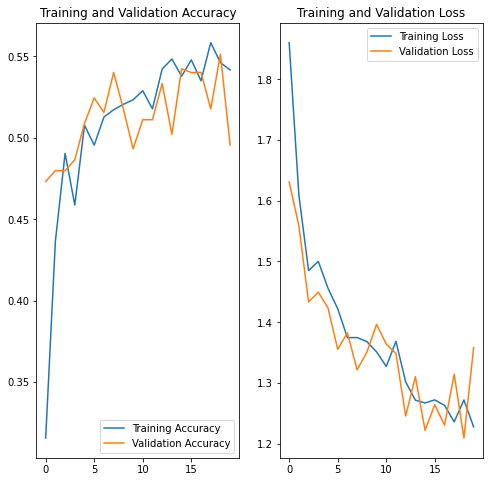

In [27]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### From the plot above, we can see that the training accuracy and the validation accuracy are very similar, therefore, implying that the problem of overfitting has been solved. But, we can see from the above scores that the performance of the model has decreased significantly from earlier and now the model is **underfitting**.

#### Since our model is underfitting now, it can be due to the following reasons:

1.   Class imbalance
2.   Simple Model

Let's explore and see if our model has class imbalance and whether rectifying it can imporove the performance of our model.



### Finding the distribution of samples in different classes


#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [28]:
import glob
class_distribution = {}

for class_name in class_names:
  class_path = pathlib.Path(str(data_dir_train) + '/' + class_name)
  num_class_samples = len(list(glob.glob(str(class_path) + '*/*.jpg')))
  class_distribution[class_name] = num_class_samples 

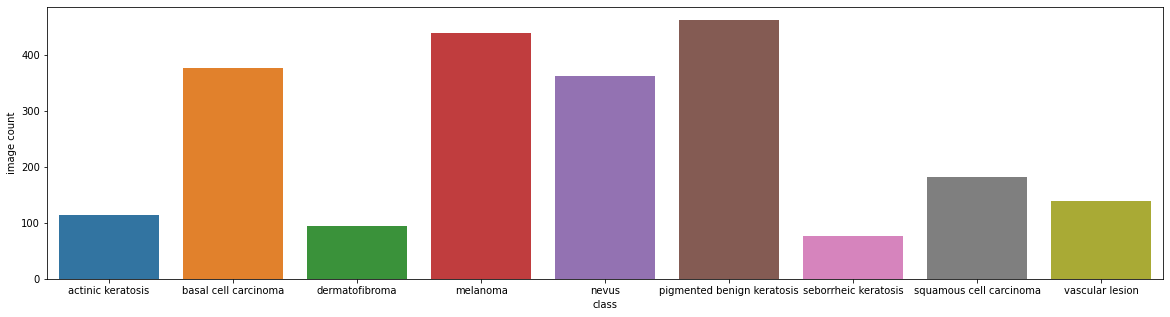

In [29]:
import seaborn as sns
df = pd.DataFrame(class_distribution.items(), columns=['class', 'image count'])

plt.figure(figsize=(20,5))
sns.barplot(x='class', y='image count', data=df)
plt.show()

#### **Todo:** Write your findings here: 
#### - Which class has the least number of samples?
#### - The class with the least number of samples is seborrheic keratosis
#### - Which classes dominate the data in terms proportionate number of samples?
#### - The classes that dominate the data are pigmented benign keratosis and melanoma


#### **Todo:** Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [30]:
!pip install Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [31]:
path_to_training_dataset = data_dir_train
print(path_to_training_dataset)
num_augmented_images = 1000
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(str(path_to_training_dataset) + '/' + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(num_augmented_images) ## We are adding 1000 samples per class to make sure that none of the classes are sparse.

/content/gdrive/MyDrive/Melanoma-detection/data/Train
Initialised with 114 image(s) found.
Output directory set to /content/gdrive/MyDrive/Melanoma-detection/data/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FB4C34EA810>: 100%|██████████| 1000/1000 [00:46<00:00, 21.71 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/gdrive/MyDrive/Melanoma-detection/data/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FB530331B50>: 100%|██████████| 1000/1000 [00:44<00:00, 22.36 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/gdrive/MyDrive/Melanoma-detection/data/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FB5BB7E4750>: 100%|██████████| 1000/1000 [00:45<00:00, 21.97 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/gdrive/MyDrive/Melanoma-detection/data/Train/melanoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x7FB5BDDCA210>: 100%|██████████| 1000/1000 [03:37<00:00,  4.60 Samples/s]


Initialised with 362 image(s) found.
Output directory set to /content/gdrive/MyDrive/Melanoma-detection/data/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=2048x1536 at 0x7FB5409E70D0>: 100%|██████████| 1000/1000 [03:23<00:00,  4.90 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/gdrive/MyDrive/Melanoma-detection/data/Train/pigmented benign keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7FB4C80BB5D0>: 100%|██████████| 1000/1000 [00:44<00:00, 22.51 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/gdrive/MyDrive/Melanoma-detection/data/Train/seborrheic keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x7FB4C8D73250>: 100%|██████████| 1000/1000 [01:45<00:00,  9.49 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/gdrive/MyDrive/Melanoma-detection/data/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FB4C8075F50>: 100%|██████████| 1000/1000 [00:46<00:00, 21.68 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/gdrive/MyDrive/Melanoma-detection/data/Train/vascular lesion/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7FB4C81A54D0>: 100%|██████████| 1000/1000 [00:46<00:00, 21.66 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [32]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

9000


### Lets see the distribution of augmented data after adding new images to the original training data.

In [33]:
path_list = [x for x in glob.glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
print(len(path_list))

9000


In [34]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob.glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
# lesion_list_new
print(len(lesion_list_new))

9000


In [35]:
dataframe_dict_new = dict(zip(path_list, lesion_list_new))

In [36]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
# new_df = original_df.append(df2)
df2.head()

,Path,Label
0,/content/gdrive/MyDrive/Melanoma-detection/dat...,vascular lesion
1,/content/gdrive/MyDrive/Melanoma-detection/dat...,vascular lesion
2,/content/gdrive/MyDrive/Melanoma-detection/dat...,vascular lesion
3,/content/gdrive/MyDrive/Melanoma-detection/dat...,vascular lesion
4,/content/gdrive/MyDrive/Melanoma-detection/dat...,vascular lesion


In [37]:
df2['Path'][0]

'/content/gdrive/MyDrive/Melanoma-detection/data/Train/vascular lesion/output/vascular lesion_original_ISIC_0033817.jpg_c777c807-d1e3-4ec5-8612-fd7567ec27cc.jpg'

In [38]:
df2['Label'].value_counts()

basal cell carcinoma          1000
seborrheic keratosis          1000
actinic keratosis             1000
nevus                         1000
dermatofibroma                1000
pigmented benign keratosis    1000
squamous cell carcinoma       1000
vascular lesion               1000
melanoma                      1000
Name: Label, dtype: int64

So, now we have added 1000 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### **Todo**: Train the model on the data created using Augmentor

In [39]:
batch_size = 32
img_height = 180
img_width = 180

#### **Todo:** Create a training dataset

In [40]:
data_dir_train = data_dir_train
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  label_mode='categorical',
  seed=123,
  validation_split = 0.2,
  subset = 'training',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 11244 files belonging to 9 classes.
Using 8996 files for training.


#### **Todo:** Create a validation dataset

In [41]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  label_mode='categorical',
  seed=123,
  validation_split = 0.2,
  subset = 'validation',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 11244 files belonging to 9 classes.
Using 2248 files for validation.


#### Checking the class distribution after data augmentation using the Augmentor library

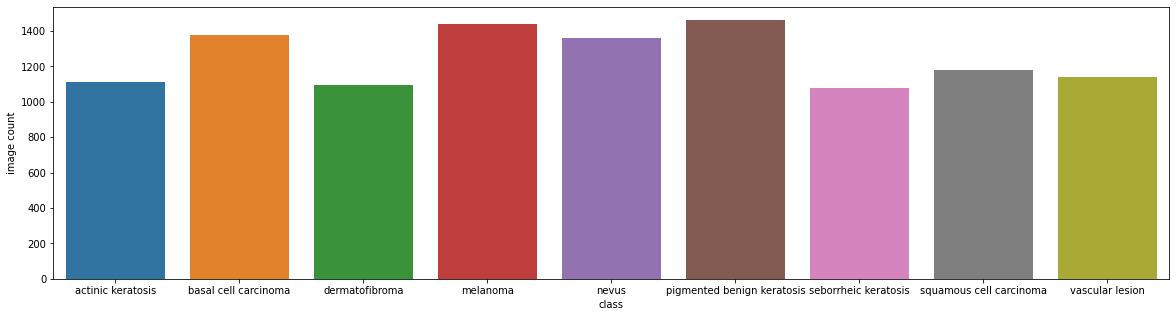

In [42]:
class_distribution = {}

for class_name in class_names:
  class_path = pathlib.Path(str(data_dir_train) + '/' + class_name)
  num_class_samples = len(list(glob.glob(str(class_path) + '*/*.jpg'))) + num_augmented_images
  class_distribution[class_name] = num_class_samples 

df = pd.DataFrame(class_distribution.items(), columns=['class', 'image count'])

plt.figure(figsize=(20,5))
sns.barplot(x='class', y='image count', data=df)
plt.show()

#### **Todo:** Create your model (make sure to include normalization)

In [43]:
model = Sequential()

model.add(normalization_layer)
model.add(Conv2D(16, 3, padding='same', activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(32, 3, padding='same', activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(64, 3, padding='same', activation='relu'))
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))

#### **Todo:** Compile your model (Choose optimizer and loss function appropriately)

In [44]:
### Todo, choose an appropirate optimiser and loss function
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 90, 90, 16)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 45, 45, 64)       

#### **Todo:**  Train your model

In [45]:
epochs = 20
## Your code goes here, use 50 epochs.
## Your code goes here, note: train your model for 20 epochs
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
282/282 [==============================] - 64s 219ms/step - loss: 1.5678 - accuracy: 0.4000 - val_loss: 1.1987 - val_accuracy: 0.5467
Epoch 2/20
282/282 [==============================] - 62s 216ms/step - loss: 1.0612 - accuracy: 0.6113 - val_loss: 0.8932 - val_accuracy: 0.6748
Epoch 3/20
282/282 [==============================] - 61s 212ms/step - loss: 0.7334 - accuracy: 0.7420 - val_loss: 0.7012 - val_accuracy: 0.7589
Epoch 4/20
282/282 [==============================] - 60s 210ms/step - loss: 0.4814 - accuracy: 0.8329 - val_loss: 0.6800 - val_accuracy: 0.7522
Epoch 5/20
282/282 [==============================] - 61s 212ms/step - loss: 0.3647 - accuracy: 0.8748 - val_loss: 0.5658 - val_accuracy: 0.8203
Epoch 6/20
282/282 [==============================] - 61s 212ms/step - loss: 0.2779 - accuracy: 0.9014 - val_loss: 0.5119 - val_accuracy: 0.8381
Epoch 7/20
282/282 [==============================] - 61s 212ms/step - loss: 0.2079 - accuracy: 0.9265 - val_loss: 0.5772 - val_ac

#### **Todo:**  Visualize the model results

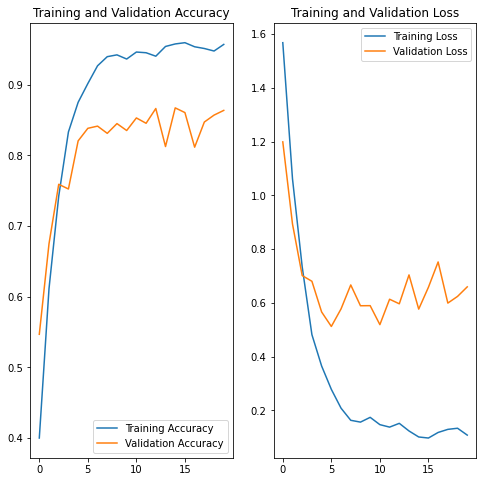

In [46]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### **Todo:**  Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?



#### The above plot shows that the previous problem of underfitting has been resolved after handling class imbalance but the high difference between between training accuracy and validation accuracy shows we still have the problem of overfitting.

### Tuning the model architecture and the hyperparameters to resolve overfitting and improve model performance

In [47]:
from keras.layers import Dropout, BatchNormalization

In [48]:
model = Sequential()

model.add(normalization_layer)
model.add(Conv2D(16, 3, padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D())
model.add(Dropout(0.2))

model.add(Conv2D(32, 3, padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D())
model.add(Dropout(0.2))

model.add(Conv2D(64, 3, padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D())
model.add(Dropout(0.2))

model.add(Flatten())

model.add(Dense(128, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))

In [49]:
### Todo, choose an appropirate optimiser and loss function
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d_9 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 batch_normalization (BatchN  (None, 180, 180, 16)     64        
 ormalization)                                                   
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 90, 90, 16)       0         
 2D)                                                             
                                                                 
 dropout (Dropout)           (None, 90, 90, 16)        0         
                                                                 
 conv2d_10 (Conv2D)          (None, 90, 90, 32)       

In [50]:
epochs = 20
## Your code goes here, use 50 epochs.
## Your code goes here, note: train your model for 20 epochs
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
282/282 [==============================] - 74s 257ms/step - loss: 2.5390 - accuracy: 0.3647 - val_loss: 53.6133 - val_accuracy: 0.0916
Epoch 2/20
282/282 [==============================] - 69s 241ms/step - loss: 1.5373 - accuracy: 0.4400 - val_loss: 12.2593 - val_accuracy: 0.2536
Epoch 3/20
282/282 [==============================] - 67s 232ms/step - loss: 1.3953 - accuracy: 0.4742 - val_loss: 1.8969 - val_accuracy: 0.4208
Epoch 4/20
282/282 [==============================] - 65s 228ms/step - loss: 1.2178 - accuracy: 0.5172 - val_loss: 1.7299 - val_accuracy: 0.3892
Epoch 5/20
282/282 [==============================] - 63s 220ms/step - loss: 1.0698 - accuracy: 0.5813 - val_loss: 1.1442 - val_accuracy: 0.5836
Epoch 6/20
282/282 [==============================] - 63s 221ms/step - loss: 0.9056 - accuracy: 0.6584 - val_loss: 1.7109 - val_accuracy: 0.4956
Epoch 7/20
282/282 [==============================] - 78s 273ms/step - loss: 0.7442 - accuracy: 0.7235 - val_loss: 2.4342 - val_

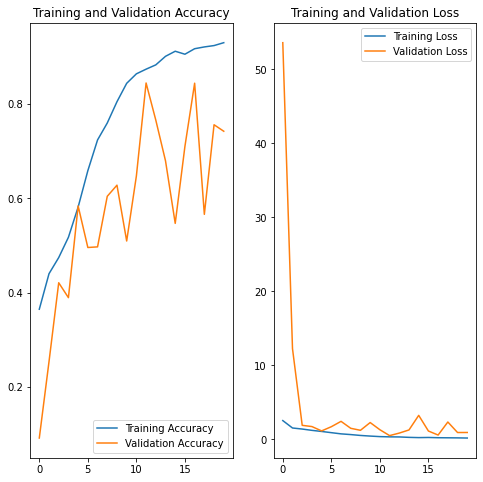

In [51]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### The above plot shows that introduing the Dropout layers and batch normalization layers did not help in resolving the overfitting.

### Experimenting more with network architecture

In [52]:
from keras.layers import Activation

In [53]:
model = Sequential()

model.add(normalization_layer)
model.add(Conv2D(32, 3, padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D())
model.add(Dropout(0.2))

model.add(Conv2D(32, 3, padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D())
model.add(Dropout(0.2))

model.add(Conv2D(64, 3, padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D())
model.add(Dropout(0.2))

model.add(Conv2D(64, 3, padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D())
model.add(Dropout(0.2))

model.add(Flatten())

model.add(Dense(64))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(128))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(Dense(num_classes, activation='softmax'))

In [54]:
### Todo, choose an appropirate optimiser and loss function
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d_12 (Conv2D)          (None, 180, 180, 32)      896       
                                                                 
 batch_normalization_3 (Batc  (None, 180, 180, 32)     128       
 hNormalization)                                                 
                                                                 
 activation (Activation)     (None, 180, 180, 32)      0         
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 90, 90, 32)       0         
 g2D)                                                            
                                                                 
 dropout_3 (Dropout)         (None, 90, 90, 32)       

In [55]:
epochs = 20
## Your code goes here, use 50 epochs.
## Your code goes here, note: train your model for 20 epochs
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
282/282 [==============================] - 65s 221ms/step - loss: 1.6262 - accuracy: 0.3741 - val_loss: 2.7976 - val_accuracy: 0.1308
Epoch 2/20
282/282 [==============================] - 63s 220ms/step - loss: 1.3847 - accuracy: 0.4684 - val_loss: 2.0092 - val_accuracy: 0.2335
Epoch 3/20
282/282 [==============================] - 64s 222ms/step - loss: 1.2450 - accuracy: 0.5248 - val_loss: 1.2231 - val_accuracy: 0.5356
Epoch 4/20
282/282 [==============================] - 63s 220ms/step - loss: 1.1633 - accuracy: 0.5545 - val_loss: 2.0078 - val_accuracy: 0.3888
Epoch 5/20
282/282 [==============================] - 63s 219ms/step - loss: 0.9905 - accuracy: 0.6216 - val_loss: 2.3406 - val_accuracy: 0.3292
Epoch 6/20
282/282 [==============================] - 63s 219ms/step - loss: 0.9123 - accuracy: 0.6527 - val_loss: 0.9600 - val_accuracy: 0.6277
Epoch 7/20
282/282 [==============================] - 63s 221ms/step - loss: 0.8244 - accuracy: 0.6853 - val_loss: 2.5681 - val_ac

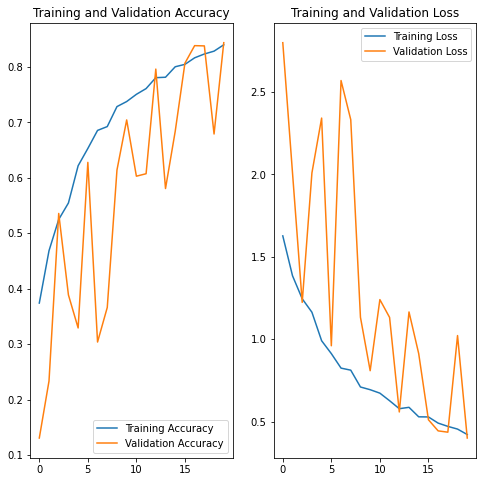

In [56]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [57]:
model = Sequential()

model.add(normalization_layer)
model.add(Conv2D(64, 3, padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D())
model.add(Dropout(0.2))

model.add(Conv2D(64, 3, padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D())
model.add(Dropout(0.2))

model.add(Conv2D(128, 3, padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D())
model.add(Dropout(0.2))

model.add(Conv2D(128, 3, padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D())
model.add(Dropout(0.2))

model.add(Flatten())

model.add(Dense(128))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(256))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(Dense(num_classes, activation='softmax'))

In [58]:
### Todo, choose an appropirate optimiser and loss function
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d_16 (Conv2D)          (None, 180, 180, 64)      1792      
                                                                 
 batch_normalization_9 (Batc  (None, 180, 180, 64)     256       
 hNormalization)                                                 
                                                                 
 activation_6 (Activation)   (None, 180, 180, 64)      0         
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 90, 90, 64)       0         
 g2D)                                                            
                                                                 
 dropout_8 (Dropout)         (None, 90, 90, 64)       

In [59]:
epochs = 20
## Your code goes here, use 50 epochs.
## Your code goes here, note: train your model for 20 epochs
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
282/282 [==============================] - 71s 239ms/step - loss: 1.5847 - accuracy: 0.3964 - val_loss: 2.6230 - val_accuracy: 0.1294
Epoch 2/20
282/282 [==============================] - 68s 237ms/step - loss: 1.3334 - accuracy: 0.4841 - val_loss: 1.7002 - val_accuracy: 0.3563
Epoch 3/20
282/282 [==============================] - 68s 237ms/step - loss: 1.1654 - accuracy: 0.5524 - val_loss: 1.3369 - val_accuracy: 0.4924
Epoch 4/20
282/282 [==============================] - 68s 235ms/step - loss: 0.9905 - accuracy: 0.6244 - val_loss: 1.5572 - val_accuracy: 0.4457
Epoch 5/20
282/282 [==============================] - 68s 235ms/step - loss: 0.8765 - accuracy: 0.6670 - val_loss: 1.0057 - val_accuracy: 0.6294
Epoch 6/20
282/282 [==============================] - 68s 238ms/step - loss: 0.7254 - accuracy: 0.7272 - val_loss: 1.0974 - val_accuracy: 0.6268
Epoch 7/20
282/282 [==============================] - 68s 237ms/step - loss: 0.6495 - accuracy: 0.7549 - val_loss: 1.1840 - val_ac

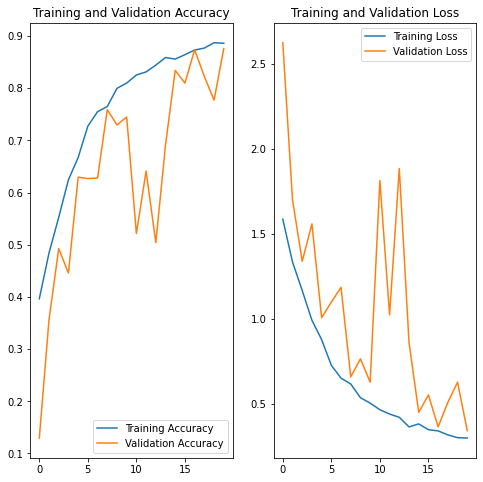

In [60]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### The above plot shows that there is not very significant difference between training accuracy and validation accuracy.

### We will try to improve the training a little more and also regularize the model a little more

### Also, introducing the concept of early stopping this time.

In [61]:
from keras.callbacks import EarlyStopping

In [62]:
model = Sequential()

model.add(normalization_layer)
model.add(Conv2D(64, 3, padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D())
model.add(Dropout(0.25))

model.add(Conv2D(64, 3, padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D())
model.add(Dropout(0.25))

model.add(Conv2D(128, 3, padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D())
model.add(Dropout(0.25))

model.add(Conv2D(128, 3, padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D())
model.add(Dropout(0.25))

model.add(Flatten())

model.add(Dense(256))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(512))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(num_classes, activation='softmax'))

In [63]:
### Todo, choose an appropirate optimiser and loss function
model.compile(optimizer=keras.optimizers.Adam(),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d_20 (Conv2D)          (None, 180, 180, 64)      1792      
                                                                 
 batch_normalization_15 (Bat  (None, 180, 180, 64)     256       
 chNormalization)                                                
                                                                 
 activation_12 (Activation)  (None, 180, 180, 64)      0         
                                                                 
 max_pooling2d_20 (MaxPoolin  (None, 90, 90, 64)       0         
 g2D)                                                            
                                                                 
 dropout_13 (Dropout)        (None, 90, 90, 64)       

In [64]:
epochs = 50

callback = EarlyStopping(monitor='val_loss', mode='min', patience=5, restore_best_weights=True)

history = model.fit(
  train_ds,
  validation_data=val_ds,
  callbacks=callback,
  epochs=epochs
)

Epoch 1/50
282/282 [==============================] - 70s 239ms/step - loss: 1.8079 - accuracy: 0.3517 - val_loss: 2.8854 - val_accuracy: 0.1290
Epoch 2/50
282/282 [==============================] - 67s 235ms/step - loss: 1.4575 - accuracy: 0.4528 - val_loss: 1.4701 - val_accuracy: 0.4057
Epoch 3/50
282/282 [==============================] - 67s 235ms/step - loss: 1.2478 - accuracy: 0.5331 - val_loss: 1.2174 - val_accuracy: 0.5307
Epoch 4/50
282/282 [==============================] - 68s 237ms/step - loss: 1.0862 - accuracy: 0.5880 - val_loss: 1.0788 - val_accuracy: 0.5961
Epoch 5/50
282/282 [==============================] - 67s 234ms/step - loss: 0.9571 - accuracy: 0.6358 - val_loss: 1.6549 - val_accuracy: 0.4524
Epoch 6/50
282/282 [==============================] - 68s 236ms/step - loss: 0.8324 - accuracy: 0.6840 - val_loss: 0.6922 - val_accuracy: 0.7282
Epoch 7/50
282/282 [==============================] - 68s 237ms/step - loss: 0.7465 - accuracy: 0.7202 - val_loss: 0.8297 - val_ac

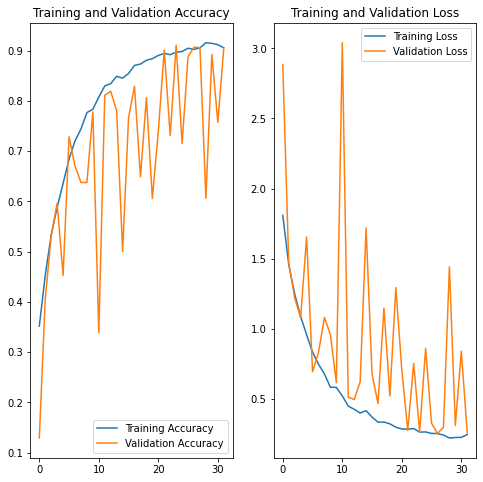

In [65]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range[:len(acc)], acc, label='Training Accuracy')
plt.plot(epochs_range[:len(val_acc)], val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range[:len(loss)], loss, label='Training Loss')
plt.plot(epochs_range[:len(val_loss)], val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### The model has overcome overfitting and is performing well on the validation data

### Checking model performance against Test data

In [66]:
test_ds = image_dataset_from_directory(
    data_dir_test,
    label_mode='categorical',
    seed=123,
    batch_size=batch_size,
    image_size=(img_height, img_width))

Found 118 files belonging to 9 classes.


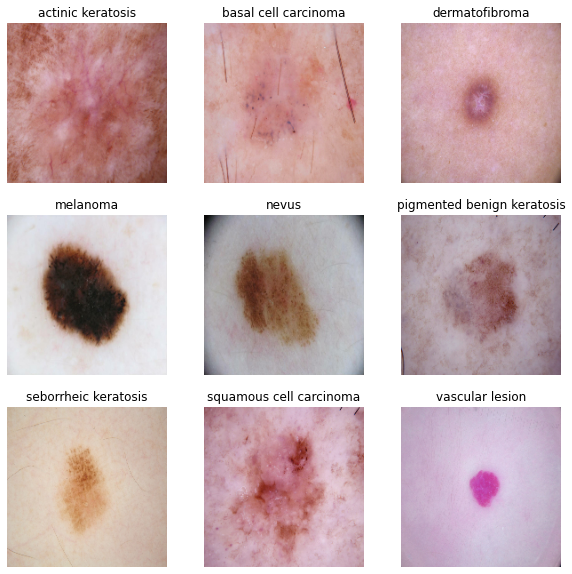

In [67]:
display_one_image_per_class(test_ds)

In [68]:
model.evaluate(test_ds)

4/4 [==============================] - 4s 208ms/step - loss: 3.1413 - accuracy: 0.5085


[3.1412527561187744, 0.508474588394165]

### The model has performed very well on the training and validation data but the performance on test data is not very good.